## Conseguir datos

In [217]:
import os
import numpy as np
import random
import xml.etree.ElementTree as etree
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.feature import hog

# https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection/code

In [2]:
#Parsetja el fitxer xml i recupera la informació necessaria per trobar la cara de l'animal
#
def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    :return annotation: diccionari
    """
    z = etree.parse(filename)
    objects = z.findall('./object')
    size = (int(float(z.find('.//width').text)), int(float(z.find('.//height').text)))
    dds = []
    for obj in objects:
        dds.append(obj.find('name').text)
        dds.append([int(float(obj.find('bndbox/xmin').text)),
                                      int(float(obj.find('bndbox/ymin').text)),
                                      int(float(obj.find('bndbox/xmax').text)),
                                      int(float(obj.find('bndbox/ymax').text))])

    return {'size': size, 'informacio': dds}

In [3]:
# Selecciona la cara de l'animal i la transforma a la mida indicat al paràmetre mida_desti
def retall_normalitzat(imatge, dades, mida_desti=(64,64)):
    """
    Extreu la regió de la cara (ROI) i retorna una nova imatge de la mida_destí
    :param imatge: imatge que conté un animal
    :param dades: diccionari extret del xml
    :mida_desti: tupla que conté la mida que obtindrà la cara de l'animal
    """
    x, y, ample, alt = dades['informacio'][1]
    retall = np.copy(imatge[y:alt, x:ample])
    return resize(retall, mida_desti)


In [57]:
def obtenir_dades(carpeta_imatges, carpeta_anotacions, mida=(64, 64)):
    """Genera la col·lecció de cares d'animals i les corresponents etiquetes
    :param carpeta_imatges: string amb el path a la carpeta d'imatges
    :param carpeta_anotacions: string amb el path a la carpeta d'anotacions
    :param mida: tupla que conté la mida que obtindrà la cara de l'animal
    :return:
        images: numpy array 3D amb la col·lecció de cares
        etiquetes: llista binaria 0 si l'animal és un moix 1 en cas contrari
    """

    imatges_elements = [entry for entry in os.listdir(carpeta_imatges) 
                    if os.path.isfile(os.path.join(carpeta_imatges, entry)) 
                    and entry.lower().endswith('.png')]
    
    n_elements = len(imatges_elements)
    # Una matriu 3D: mida x mida x nombre d'imatges
    imatges = np.zeros((mida[0], mida[1], n_elements), dtype=np.float16)
    # Una llista d'etiquetes
    etiquetes = [0] * n_elements

    #  Recorre els elements de les dues carpetes: llegeix una imatge i obté la informació interessant del xml
    for idx, element in enumerate(imatges_elements):
        nom = element.split(".")
        nom_fitxer = nom[0] + ".xml"

        path_anotacio = os.path.join(carpeta_anotacions, nom_fitxer)
        #if not os.path.exists(path_anotacio):
            #print(f"Advertència: L'anotació {nom_fitxer} no existeix.")
            #continue
        imatge_path = os.path.join(carpeta_imatges, element)
        imatge = imread(imatge_path, as_gray=True)
        #try:
            #imatge = imread(imatge_path, as_gray=True)
        #except OSError as e:
            #print(f"Error en llegir la imatge {element}: {e}")
            #continue

        anotacions = extract_xml_annotation(path_anotacio)
        
        cara_animal = retall_normalitzat(imatge, anotacions, mida)
        tipus_animal = anotacions["informacio"][0]
        
        imatges[:, :, idx] = cara_animal
        
        etiquetes[idx] = 0 if tipus_animal == "cat" else 1

    return imatges, etiquetes

In [330]:
def obtenirHoG(imatges):

    pixels_bloc = (8, 8)
    orientacions = 10
    blocs = (2, 2)

    descriptors = []
    imatges_hog = []

    for idx in range(imatges.shape[2]):

        imatge = imatges[:, :, idx]
        descriptor, imatge = hog(imatge,
                                 orientations=orientacions,
                                 pixels_per_cell=pixels_bloc,
                                 cells_per_block=blocs,
                                 block_norm='L2-Hys',
                                 visualize=True,
                                 transform_sqrt=True)
        
        descriptors.append(descriptor)
        imatges_hog.append(imatge)

    descriptors = np.array(descriptors)   
    imatges_hog = np.array(imatges_hog)
    
    return descriptors, imatges_hog

In [259]:
def showHoGVariations(imatge, hogParams):
    fig, axes = plt.subplots(1, len(hogParams)+1, figsize=(15, 15))

    axes[0].imshow(imatge, cmap='gray')
    axes[0].axis('off')
    
    for idx, params in enumerate(hogParams):
        #print(f"HoG Params {params}")
    
        _, imatge_hog = hog(imatges[:, :, randomIdx],
                                 orientations=params[1],
                                 pixels_per_cell=params[0],
                                 cells_per_block=params[2],
                                 block_norm='L2-Hys',
                                 visualize=True,
                                 transform_sqrt=True)

        axes[idx+1].imshow(imatge_hog, cmap='gray')
        axes[idx+1].set_title(f"HoG Params {params}")
        axes[idx+1].axis('off')

    plt.tight_layout()
    plt.show()

In [396]:
carpeta_images = "gatigos/images2"  # NO ES POT MODIFICAR
carpeta_anotacions = "gatigos/annotations2"  # NO ES POT MODIFICAR
mida = (128, 128)  # DEFINEIX LA MIDA, ES RECOMANA COMENÇAR AMB 64x64
imatges, etiquetes = obtenir_dades(carpeta_images, carpeta_anotacions, mida)

caracteristiques, imatges_hog = obtenirHoG(imatges)

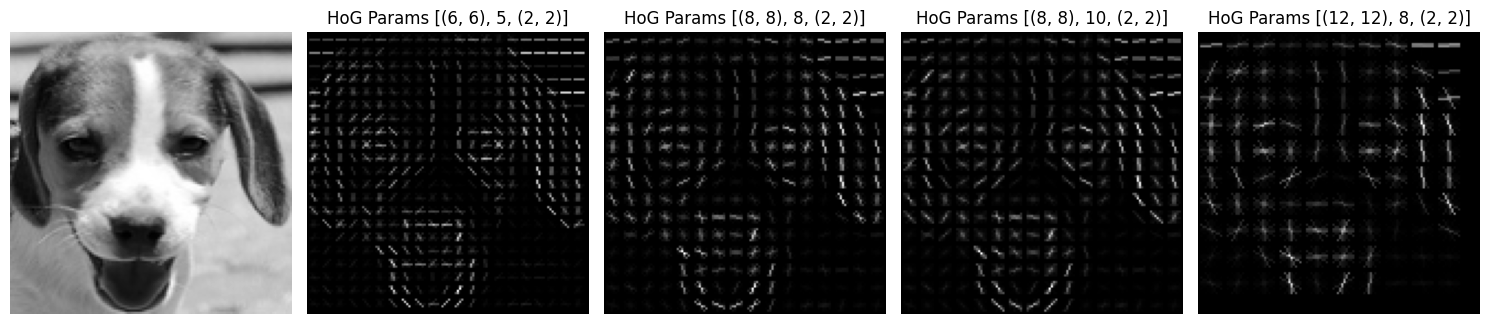

In [397]:
randomIdx = 74
randomIdx = random.randint(0,len(imatges)-1)
params = [[(6, 6), 5, (2, 2)], 
          [(8, 8), 8, (2, 2)],
          [(8, 8), 10, (2, 2)], 
          [(12, 12), 8, (2, 2)]]

showHoGVariations(imatges[:, :, randomIdx], params)

## Modelo de clasificación

In [399]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from scipy.spatial import distance_matrix
from sklearn.inspection import DecisionBoundaryDisplay

In [401]:
X_train, X_test, y_train, y_test = train_test_split(caracteristiques, etiquetes, test_size=0.33, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(np.transpose(imatges, (2, 0, 1)), etiquetes, test_size=0.33, random_state=42)

In [402]:
scaler = MinMaxScaler()  #StandardScaler()
X_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [403]:
gamma = 1.0 / (X_transformed.shape[1] * X_transformed.var())
C = 1.0
random_state = 33
kernels = ["linear", "rbf", "poly"]

In [404]:
for kernel in kernels: # obtindrem les claus del diccionari "linear", "rbf", "poly"

    print(f"TEST KERNEL: {kernel}")
    svm = SVC(C=C, kernel=kernel, random_state=random_state)
    svm.fit(X_transformed, y_train)
    y_predict = svm.predict(X_test_transformed)

    print(y_predict[0:5])
    
    print(" Resultats:")
    precision_scikit = precision_score(y_test, y_predict)
    print(f"   Precisió: {precision_scikit}")

TEST KERNEL: linear
[0 1 0 0 1]
 Resultats:
   Precisió: 0.9318181818181818
TEST KERNEL: rbf
[1 1 0 0 1]
 Resultats:
   Precisió: 0.8823529411764706
TEST KERNEL: poly
[0 1 0 0 1]
 Resultats:
   Precisió: 0.9166666666666666


In [405]:
y_test[0:5]

[0, 1, 0, 0, 1]

Imagen 0 real es 0


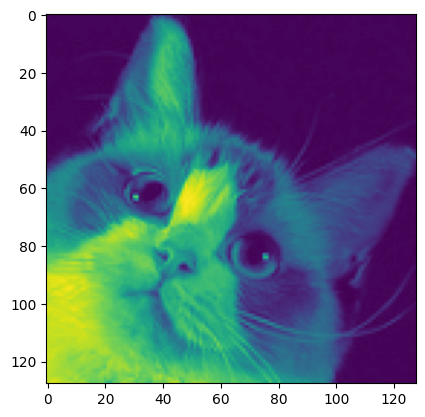

Imagen 1 real es 1


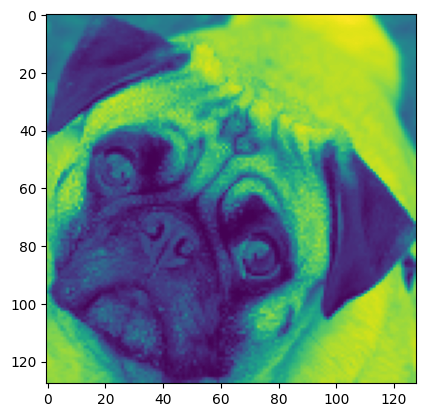

Imagen 2 real es 0


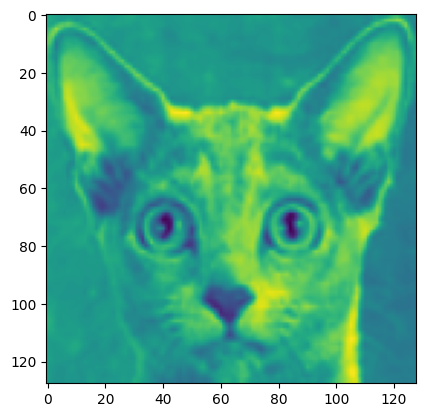

Imagen 3 real es 0


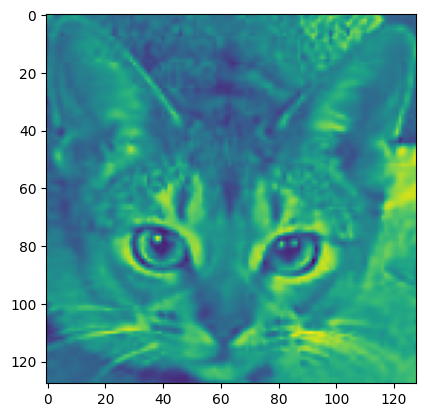

Imagen 4 real es 1


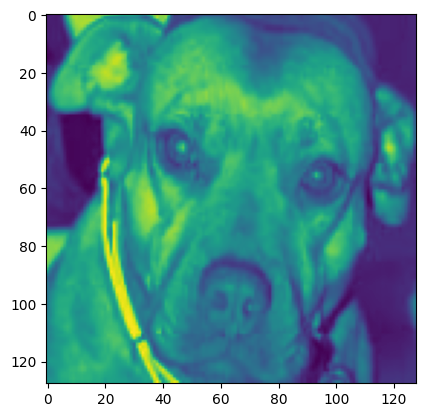

In [406]:
for i in range(5):
    print(f"Imagen {i} real es {y_test[i]}")
    plt.imshow(X_test2[i,:,:])
    plt.show()